# Airline Tweet Sentiment Analysis

Carry out the sentiment analysis of tweets sent out to airlines.

The project will be separated into two portions:

* Data Preparation and Exploration
* Modelling

## Data Preparation and Exploration
Load the data, explore it and prepare it for modelling.

### Import the necessary modules


In [ ]:
#Install ktrain
!pip install ktrain

In [ ]:
#Import the necessary libraries

import os

import ktrain
from ktrain import text

import re
import pandas as pd
import numpy as np
from zipfile import ZipFile
import seaborn as sns
from sklearn.model_selection import train_test_split


### Retrieve data

In [ ]:
# Your username and kaggle token


In [ ]:
# Download the data from the kaggle competition

raw_data_dir = "input/"

!kaggle datasets download -d crowdflower/twitter-airline-sentiment -p {raw_data_dir}

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 84.4MB/s]


Reference: https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/198299

In [ ]:
#Unzip the train data first
zip_ref = ZipFile('/content/input/twitter-airline-sentiment.zip', 'r')
zip_ref.extractall('/content/input/')

In [ ]:
# Save in a variable for exploration
tweets = pd.read_csv('/content/input/Tweets.csv')

### Explore the data

In [ ]:
# View the data
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# Tweets info
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

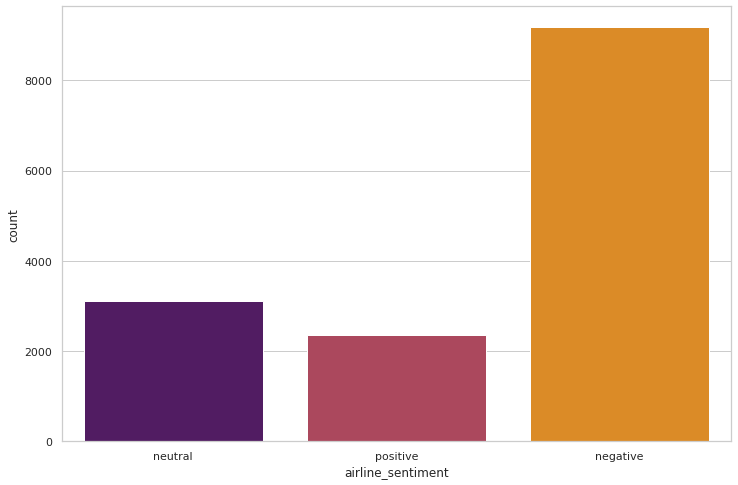

In [ ]:
# View the value counts of the sentiments

sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('airline_sentiment', data=tweets, palette='inferno')

In [ ]:
# View the percentage of the sentiments

tweets.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

The negative sentiments are alot more compared to the positive and neutral sentiments making up 62% of the sentiments.

### Prepare the data
Get the data ready for modelling. Save it into two variables for later.

In [ ]:
# Subset the data
tweets_subset = tweets[['text', 'airline_sentiment']]

tweets_EDA = tweets_subset.copy()

In [ ]:
# View the tweets subset data
tweets_subset.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
categories = ['positive', 'neutral', 'negative']

In [ ]:
# Create a list of texts
texts = tweets_subset.text.values


In [ ]:
# Clean the texts
new_texts = []
for text in texts:
  text = ' '.join(re.sub("(@[A-Za-z0–9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
  new_texts.append(text)
  

[Text(0, 0.5, 'count'),
 Text(0.5, 0, 'length of words'),
 Text(0.5, 1.0, 'Length of Words Plot')]

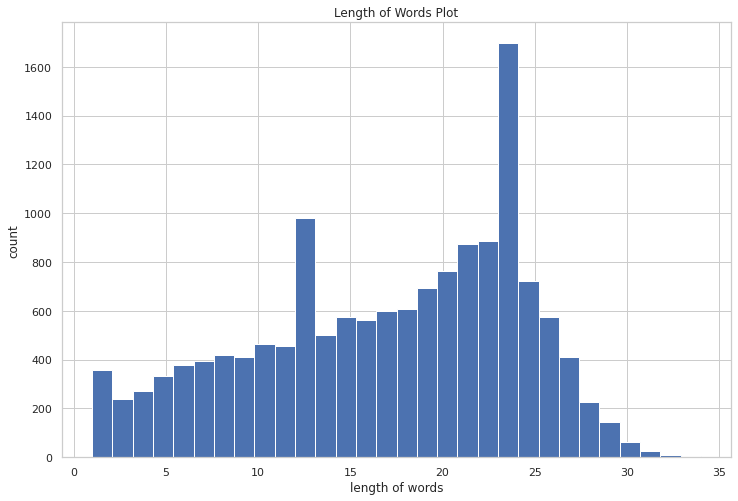

In [ ]:
# get length of all the messages in the train set
sequence_length = [len(text.split()) for text in new_texts]

pd.Series(sequence_length).hist(bins = 30).set(xlabel='length of words',
                                               ylabel='count',
                                               title='Length of Words Plot')


## Modelling

### Model without Augmentation

In [ ]:
#Prepare the data
X = np.array(new_texts)
y = tweets_subset['airline_sentiment'].to_numpy()

features_train, features_test, labels_train, labels_test = train_test_split(X,
                                                                            y,
                                                                            train_size=0.8,
                                                                            random_state=42,
                                                                            stratify=y)



In [ ]:
# Instantiate the model
model_name = 'distilbert-base-uncased'

transformer = text.Transformer(model_name=model_name,
                               maxlen=30, 
                               class_names=categories,
                               batch_size=32)

In [ ]:
# Combine the data for the model

train_data = transformer.preprocess_train(features_train, labels_train)
test_data = transformer.preprocess_test(features_test, labels_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 17
	95percentile : 27
	99percentile : 29


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 17
	95percentile : 27
	99percentile : 29


In [ ]:
# Create model
model = transformer.get_classifier()

In [ ]:
# Create a learner
learner = ktrain.get_learner(model, train_data, test_data, batch_size=32)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
366/366 [==============================] - 50s 111ms/step - loss: 1.1090 - accuracy: 0.2839
Epoch 2/5
366/366 [==============================] - 44s 114ms/step - loss: 0.6363 - accuracy: 0.7322
Epoch 3/5
366/366 [==============================] - 45s 118ms/step - loss: 0.6348 - accuracy: 0.7537
Epoch 4/5
366/366 [==============================] - 34s 87ms/step - loss: 3.0709 - accuracy: 0.6040


done.
Visually inspect loss plot and select learning rate associated with falling loss


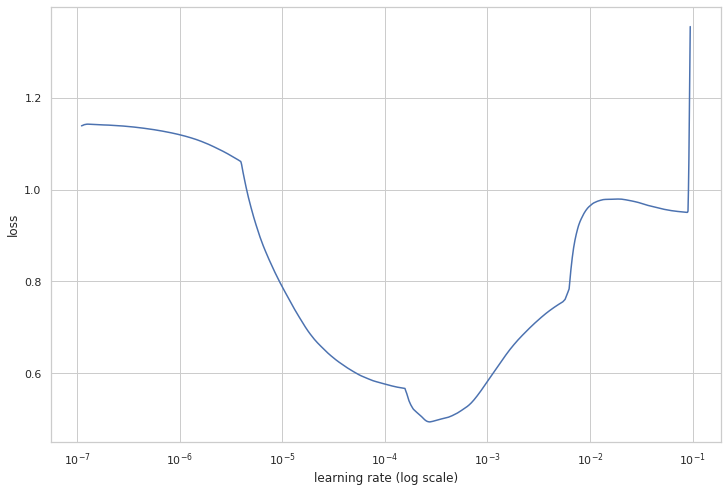

In [ ]:
# Find the best learning rate
learner.lr_find(max_epochs = 5, show_plot=True)

In [ ]:
#fit learner
learner.fit_onecycle(5e-5, 5)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/5
366/366 [==============================] - 105s 250ms/step - loss: 0.8053 - accuracy: 0.6633 - val_loss: 0.4961 - val_accuracy: 0.8074
Epoch 2/5
366/366 [==============================] - 93s 245ms/step - loss: 0.4003 - accuracy: 0.8482 - val_loss: 0.4432 - val_accuracy: 0.8289
Epoch 3/5
366/366 [==============================] - 93s 245ms/step - loss: 0.2765 - accuracy: 0.9018 - val_loss: 0.4748 - val_accuracy: 0.8197
Epoch 4/5
366/366 [==============================] - 93s 245ms/step - loss: 0.1497 - accuracy: 0.9505 - val_loss: 0.5647 - val_accuracy: 0.8289
Epoch 5/5
366/366 [==============================] - 93s 245ms/step - loss: 0.0589 - accuracy: 0.9824 - val_loss: 0.6871 - val_accuracy: 0.8221


In [ ]:
# Evaluate model
learner.validate(class_names=transformer.get_classes())


              precision    recall  f1-score   support

    negative       0.89      0.90      0.89      1836
     neutral       0.66      0.68      0.67       620
    positive       0.77      0.72      0.74       472

    accuracy                           0.82      2928
   macro avg       0.77      0.76      0.77      2928
weighted avg       0.82      0.82      0.82      2928



array([[1647,  136,   53],
       [ 151,  422,   47],
       [  53,   81,  338]])

The model achieves an overall accuracy of **82%**.

### Modelling with data Augmentation

In [ ]:
#Install the nlpaug module
!pip install numpy requests nlpaug

     |████████████████████████████████| 389kB 6.5MB/s 


In [ ]:
# import the word augmentor module
import nlpaug.augmenter.word as naw


In [ ]:
# encode the sentiments
mapping = {'positive': 1,
           'neutral': 0,
           'negative': 2}

tweets_subset.loc[:, 'airline_sentiment'] = tweets_subset.airline_sentiment.map(mapping)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [ ]:
#Define the augmentor
aug = naw.SynonymAug(aug_p=0.1)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def augmentor(dataframe):
  ''' Creates an augmented dataframe'''
  #Separate the positive, negative and neutral examples
  positive_examples = dataframe[dataframe.airline_sentiment == 1].reset_index(drop=True)
  neutral_examples = dataframe[dataframe.airline_sentiment == 0].reset_index(drop=True)
  negative_examples = dataframe[dataframe.airline_sentiment == 2].reset_index(drop=True)

  #Convert labels to augment to list
  positive_list = positive_examples['texts'].values.tolist()
  neutral_list = neutral_examples['texts'].values.tolist()

  #Augment
  positives = []
  neutrals = []

  for text in positive_list:
    new = aug.augment(text, n=3)
    positives.extend(new)

  for text in neutral_list:
    new = aug.augment(text, n=2)
    neutrals.extend(new)

  #Combine with the original
  positive_list.extend(positives)
  neutral_list.extend(neutrals)

  #create dataframes
  positive_df = pd.DataFrame({'texts': np.array(positive_list),
                              'airline_sentiment': 1})
  neutrals_df = pd.DataFrame({'texts': np.array(neutral_list),
                              'airline_sentiment': 0})
  
  #Combine and shuffle dataframes
  pre_combined_df = pd.concat([positive_df, neutrals_df, negative_examples],
                              ignore_index=True)
  
  combined_df = pre_combined_df.sample(frac=1).reset_index(drop=True)

  return combined_df


  



In [ ]:
# Convert new texts array to a dataframe
new_texts = pd.DataFrame(new_texts, columns=['text'])

In [ ]:
# Concatenate new texts with the airline sentiment to make a dataframe that will be later split into train and test
new_df = pd.concat([new_texts, tweets_subset['airline_sentiment']], axis = 1)

In [ ]:
# Split data into train and test
train, test = train_test_split(new_df, train_size=0.8, random_state=42)

In [ ]:
#Augment the data

new_train = augmentor(train)

In [ ]:
#Check for balance
new_train.airline_sentiment.value_counts(normalize=True)

1    0.339062
0    0.336435
2    0.324504
Name: airline_sentiment, dtype: float64

In [ ]:
# Instantiate the model
model_name = 'distilbert-base-uncased'

new_categories = [0, 1, 2]

transformer = text.Transformer(model_name=model_name,
                               maxlen=30, 
                               class_names=new_categories,
                               batch_size=32)

In [ ]:
#Prepare data

#Convert to arrays
x_train_array = new_train['texts'].to_numpy()
y_train_array = new_train['airline_sentiment'].to_numpy()

x_test_array = test['texts'].to_numpy()
y_test_array = test['airline_sentiment'].to_numpy()

# Convert to ktrain dataset
train_dataset = transformer.preprocess_train(x_train_array, y_train_array)
test_dataset = transformer.preprocess_test(x_test_array, y_test_array)




preprocessing train...
language: en
train sequence lengths:
	mean : 15
	95percentile : 26
	99percentile : 29


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 17
	95percentile : 27
	99percentile : 29


In [ ]:
# Create model
model = transformer.get_classifier()


In [ ]:
#Train the model

aug_learner = ktrain.get_learner(model, train_dataset, test_dataset, batch_size=32)

In [ ]:
#Fit learner
aug_learner.fit_onecycle(5e-5, 5)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/5
702/702 [==============================] - 183s 239ms/step - loss: 0.7809 - accuracy: 0.6417 - val_loss: 0.4511 - val_accuracy: 0.8327
Epoch 2/5
702/702 [==============================] - 172s 236ms/step - loss: 0.3112 - accuracy: 0.8919 - val_loss: 0.5051 - val_accuracy: 0.8159
Epoch 3/5
702/702 [==============================] - 172s 236ms/step - loss: 0.1559 - accuracy: 0.9499 - val_loss: 0.6033 - val_accuracy: 0.8337
Epoch 4/5
702/702 [==============================] - 172s 236ms/step - loss: 0.0639 - accuracy: 0.9810 - val_loss: 0.7325 - val_accuracy: 0.8344
Epoch 5/5
702/702 [==============================] - 172s 236ms/step - loss: 0.0333 - accuracy: 0.9910 - val_loss: 0.8172 - val_accuracy: 0.8344


In [ ]:
# Evaluate model
aug_learner.validate(class_names=transformer.get_classes())

              precision    recall  f1-score   support

           0       0.68      0.61      0.65       580
           1       0.79      0.79      0.79       459
           2       0.89      0.91      0.90      1889

    accuracy                           0.83      2928
   macro avg       0.79      0.77      0.78      2928
weighted avg       0.83      0.83      0.83      2928



array([[ 355,   54,  171],
       [  45,  362,   52],
       [ 120,   43, 1726]])

With data augmentation, the model has a one percent increase in accuracy, getting an accuracy of **83%**